# Bikeshare 

In [277]:
import pandas as pd
import numpy as np
from tabulate import tabulate
import inspect
import seaborn as sns 
import matplotlib.pyplot as plt

In [278]:
day = pd.read_csv('Bike-Sharing-Dataset/day.csv', index_col=0) 
hour = pd.read_csv('Bike-Sharing-Dataset/hour.csv', index_col=0)

data = [day, hour]

for df in data: # Change the coloumn names to something I feel more used to. 
    df.rename(columns={"dteday": "date", "cnt": "total_rentals", 'casual': 'casual_rentals', 'registered': 'registered_rentals', 'mnth':'month'}, inplace=True)


### Functions might be used to make my life easier:

In [279]:
def retrieve_name(var):
        """
        Gets the name of var. Does it from the out most frame inner-wards.
        :param var: variable to get name from.
        :return: string
        """
        for fi in reversed(inspect.stack()):
            names = [var_name for var_name, var_val in fi.frame.f_locals.items() if var_val is var]
            if len(names) > 0:
                return names[0]

In [280]:
def missing(df):

    total = df.isnull().sum().sort_values(ascending=False)
    percent_1 = df.isnull().sum()/df.isnull().count()*100
    percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
    missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
    return missing_data.head(5)

In [281]:
def list_columns(df):
    for col in df: 
        print(col, end='   ')
        

In [282]:
def get_cname(df,col):
    return df.columns[df.columns.get_loc(col)]  # <--- Is ther a nicer way to do this?



In [283]:
day.columns[1]

'season'

In [284]:
df = day
col = 'season'
df.columns[df.columns.get_loc(col)]

'season'

In [285]:
list_columns(day)

date   season   yr   month   holiday   weekday   workingday   weathersit   temp   atemp   hum   windspeed   casual_rentals   registered_rentals   total_rentals   

In [286]:
def explore(*args):
    for arg in args:
        print('Data exploration for',retrieve_name(arg),':','\n')
        print(arg.info(),'\n')
        #print('Describe the data:\n',arg.describe().round(2),'\n')
        for col in arg:
            if len(arg[col].unique()) < 50:
                print('List unique values of column',col,':')
                print(arg[col].unique()) 
        print('\n','Missing Values:\n',missing(arg),'\n\n\n') 
        print('Column names for',retrieve_name(arg),':\n')
        for col_name in arg.columns: 
            print(col_name, end='   ')
        print('\n')

In [287]:
print("Hello there!", end = '')
print("It is a great day.")

Hello there!It is a great day.


### Targets

- Improve availability of bikes for working professionals / salaried employees as they are the most valued customers.
- Improve availability of bikes for casual customers.
- Provide statistics about contribution of weather in bike demands.
- Provide statistics about how traffic and pollution affect sales.



### Questions

- Is there a correlation between temp and feeled temp?
- Is there a correlation between temp, atemp and the toal bike rentals?
- Is there a correlation between season and feeled temp / temp?

## Data Exploration

In [288]:
explore(day, hour)

Data exploration for day : 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 731 entries, 1 to 731
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   date                731 non-null    object 
 1   season              731 non-null    int64  
 2   yr                  731 non-null    int64  
 3   month               731 non-null    int64  
 4   holiday             731 non-null    int64  
 5   weekday             731 non-null    int64  
 6   workingday          731 non-null    int64  
 7   weathersit          731 non-null    int64  
 8   temp                731 non-null    float64
 9   atemp               731 non-null    float64
 10  hum                 731 non-null    float64
 11  windspeed           731 non-null    float64
 12  casual_rentals      731 non-null    int64  
 13  registered_rentals  731 non-null    int64  
 14  total_rentals       731 non-null    int64  
dtypes: float64(4), int64(10), ob

## Preprocessing

### Categorize Data

Both hour.csv and day.csv have the following fields, except hr which is not available in day.csv


#### Original columns:

- instant: record index
- dteday : date
- season : season (1:winter, 2:spring, 3:summer, 4:fall)
- yr : year (0: 2011, 1:2012)
- mnth : month ( 1 to 12)
- hr : hour (0 to 23)
- holiday : weather day is holiday or not (extracted from [Web Link])
- weekday : day of the week
- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
 weathersit:
  - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
  - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
  - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
  - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp : Normalized temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39 (only in hourly scale)
- atemp: Normalized feeling temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-16, t_max=+50 (only in hourly scale)
- hum: Normalized humidity. The values are divided to 100 (max)
- windspeed: Normalized wind speed. The values are divided to 67 (max)
- casual: count of casual users
- registered: count of registered users
- cnt: count of total rental bikes including both casual and registered

#### New columns:

- raw_tem
- raw_atemp
- raw_hum

### Data Transformation / Categorization 

In [289]:
# Categorizing numeric values and further transformation. 
# Adding ne columns. 

temp_categories = ['Death','Frigid','Freezing','Very Cold','Cold','Cool','Mild','Warm','Hot','Very Hot','Extremly Hot']
temp_categorie_values = [-100,-15,-10,-3,3,12,17,25,33,40,45,100] # <-- Can i set the outer limits to infinite? 

##y = 'hello'  deep copy and shallow copy 

# All mapings in this for loop will be applied to day and hour. 
for df in data: # Data has been defined data = [day, hour]
    df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')# <-- How to change the datetime format to '%d.%m.%Y' | This was changing the dtype --> .dt.strftime('%m/%d/%Y')

    df['cat_season'] = df['season'].map({1:'Winter', 2:'Spring', 3:'Summer', 4:'Fall'})
    df['cat_is_holiday'] = df['holiday'].map({0:'No', 1:'Yes'})
    
    df['cat_yr'] = df['yr'].map({0:'2011', 1:'2012'})

    df['raw_temp'] = 39*df['temp']-(-8)*df['temp']+(-8)
    df['raw_atemp'] = 39*df['temp']-(-16)*df['temp']+(-16)
    df['raw_hum'] = df['hum']*100
    df['raw_windspeed'] = df['windspeed']*67

    df['cat_weathersit'] = df['weathersit'].map({1:'nice', 2:'cloudy', 3:'wet', 4:'lousy'})
    df['cat_temp'] = pd.cut(df['raw_temp'], temp_categorie_values, labels=temp_categories) # Depends on raw_temp
    df['cat_atemp'] = pd.cut(df['raw_atemp'], temp_categorie_values, labels=temp_categories) # Depends on raw_atemp

    df['cat_holiday'] = df['holiday'].map({1:'Yes', 0:'No'})
    df['cat_weekend'] = (df['date'].dt.weekday // 5).map({1:'Yes', 0:'No'})
    df['cat_workingday'] = (df['date'].dt.weekday // 5).map({1:'No', 0:'Yes'})
    
    df['cat_weekday'] = df['date'].dt.day_name() 
    df['cat_month'] = df['date'].dt.month_name()


In [290]:
#sns.pairplot(day)

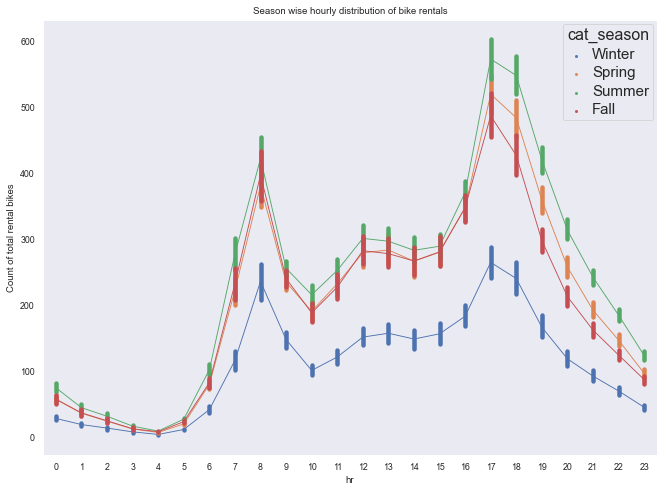

In [291]:
sns.set(rc={'figure.figsize':(11,8)})
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.5})
#sns.set(style="ticks", context="talk")
#plt.style.use("dark_background")
sns.set_style("dark")

#fig, ax = plt.subplots()
ax = sns.pointplot(data = hour[['hr','total_rentals','cat_season']], x = 'hr', y = 'total_rentals',
              scale = 0.2, hue = 'cat_season');

plt.setp(ax.get_legend().get_texts(), fontsize='15') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='16') # for legend title

ax.set(title = 'Season wise hourly distribution of bike rentals',ylabel= 'Count of total rental bikes');

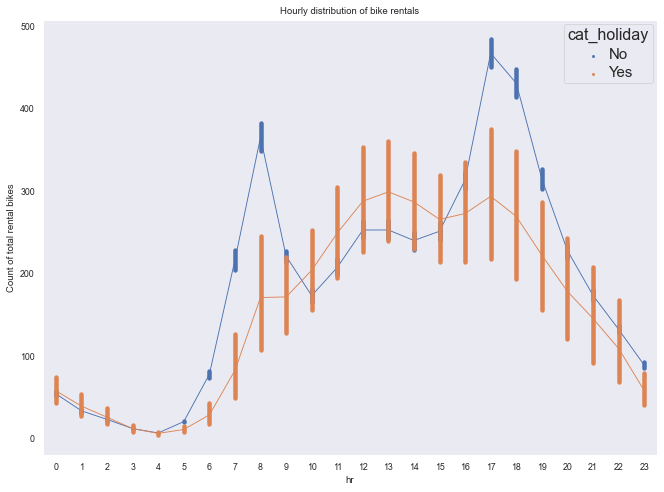

In [292]:
sns.set(rc={'figure.figsize':(11,8)})
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.5})
#sns.set(style="ticks", context="talk")
#plt.style.use("dark_background")
sns.set_style("dark")

#fig, ax = plt.subplots()
ax = sns.pointplot(data = hour[['hr','total_rentals','cat_holiday']], x = 'hr', y = 'total_rentals',
              scale = 0.2, hue = 'cat_holiday');

plt.setp(ax.get_legend().get_texts(), fontsize='15') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='16') # for legend title

ax.set(title = 'Hourly distribution of bike rentals',ylabel= 'Count of total rental bikes',);

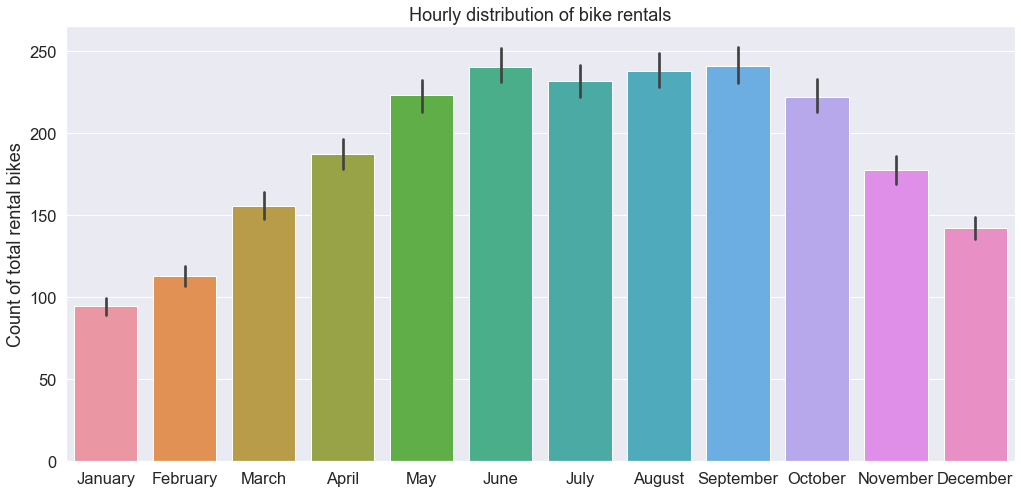

In [293]:
sns.set(rc={'figure.figsize':(17,8)})
sns.set(font_scale = 1.5)

ax = sns.barplot(x="cat_month", y="total_rentals", data=hour,)
ax.set(title = 'Hourly distribution of bike rentals',ylabel='Count of total rental bikes', xlabel='');

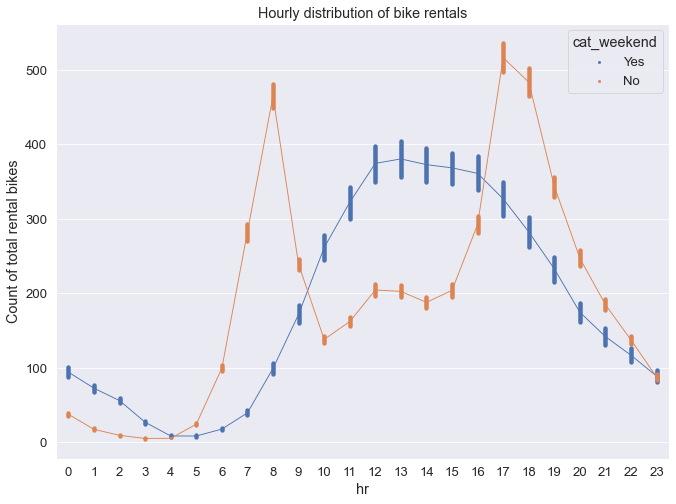

In [302]:
sns.set(rc={'figure.figsize':(11,8)})
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.5})

ax = sns.pointplot(data = hour[['hr','total_rentals','cat_weekend']], x = 'hr', y = 'total_rentals',
              scale = 0.2, hue = 'cat_weekend');

#plt.setp(ax.get_legend().get_texts(), fontsize='15') # for legend text
#plt.setp(ax.get_legend().get_title(), fontsize='16') # for legend title

ax.set(title = 'Hourly distribution of bike rentals', ylabel= 'Count of total rental bikes');

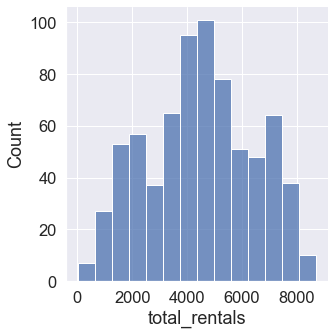

In [298]:
sns.set(rc={'figure.figsize':(18,8)})
sns.set(font_scale = 1.5)

sns.displot(day.total_rentals)

In [296]:
day.head(100)

,date,season,yr,month,holiday,weekday,workingday,weathersit,temp,atemp,...,raw_hum,raw_windspeed,cat_weathersit,cat_temp,cat_atemp,cat_holiday,cat_weekend,cat_workingday,cat_weekday,cat_month
instant,,,,,,,,,,,,,,,,,,,,,
1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,...,80.5833,10.749882,cloudy,Cold,Very Cold,No,Yes,No,Saturday,January
2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,...,69.6087,16.652113,cloudy,Cold,Cold,No,Yes,No,Sunday,January
3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,...,43.7273,16.636703,nice,Very Cold,Freezing,No,No,Yes,Monday,January
4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,...,59.0435,10.739832,nice,Very Cold,Freezing,No,No,Yes,Tuesday,January
5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,...,43.6957,12.522300,nice,Very Cold,Freezing,No,No,Yes,Wednesday,January
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,2011-04-06,2,0,4,0,3,1,1,0.390833,0.387608,...,47.0833,17.625221,nice,Cold,Cold,No,No,Yes,Wednesday,April
97,2011-04-07,2,0,4,0,4,1,1,0.437500,0.433696,...,60.2917,10.874904,nice,Cool,Cold,No,No,Yes,Thursday,April
98,2011-04-08,2,0,4,0,5,1,2,0.335833,0.324479,...,83.6250,15.208464,cloudy,Cold,Very Cold,No,No,Yes,Friday,April


# What i want to do:

